![Two data scientists working on a dashboard.](hr-image-small.png)

A common problem when creating models to generate business value from data is that the datasets can be so large that it can take days for the model to generate predictions. Ensuring that your dataset is stored as efficiently as possible is crucial for allowing these models to run on a more reasonable timescale without having to reduce the size of the dataset.

You've been hired by a major online data science training provider called *Training Data Ltd.* to clean up one of their largest customer datasets. This dataset will eventually be used to predict whether their students are looking for a new job or not, information that they will then use to direct them to prospective recruiters.

You've been given access to `customer_train.csv`, which is a subset of their entire customer dataset, so you can create a proof-of-concept of a much more efficient storage solution. The dataset contains anonymized student information, and whether they were looking for a new job or not during training:

| Column                   | Description                                                                      |
|------------------------- |--------------------------------------------------------------------------------- |
| `student_id`             | A unique ID for each student.                                                    |
| `city`                   | A code for the city the student lives in.                                        |
| `city_development_index` | A scaled development index for the city.                                         |
| `gender`                 | The student's gender.                                                            |
| `relevant_experience`    | An indicator of the student's work relevant experience.                          |
| `enrolled_university`    | The type of university course enrolled in (if any).                              |
| `education_level`        | The student's education level.                                                   |
| `major_discipline`       | The educational discipline of the student.                                       |
| `experience`             | The student's total work experience (in years).                                  |
| `company_size`           | The number of employees at the student's current employer.                       |
| `company_type`           | The type of company employing the student.                                       |
| `last_new_job`           | The number of years between the student's current and previous jobs.             |
| `training_hours`         | The number of hours of training completed.                                       |
| `job_change`             | An indicator of whether the student is looking for a new job (`1`) or not (`0`). |

city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64 

Male      13221
Female     1238
Other       191
Name: gender, dtype: int64 

Has relevant experience    13792
No relevant experience      5366
Name: relevant_experience, dtype: int64 

no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64 

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64 

STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64 

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
1

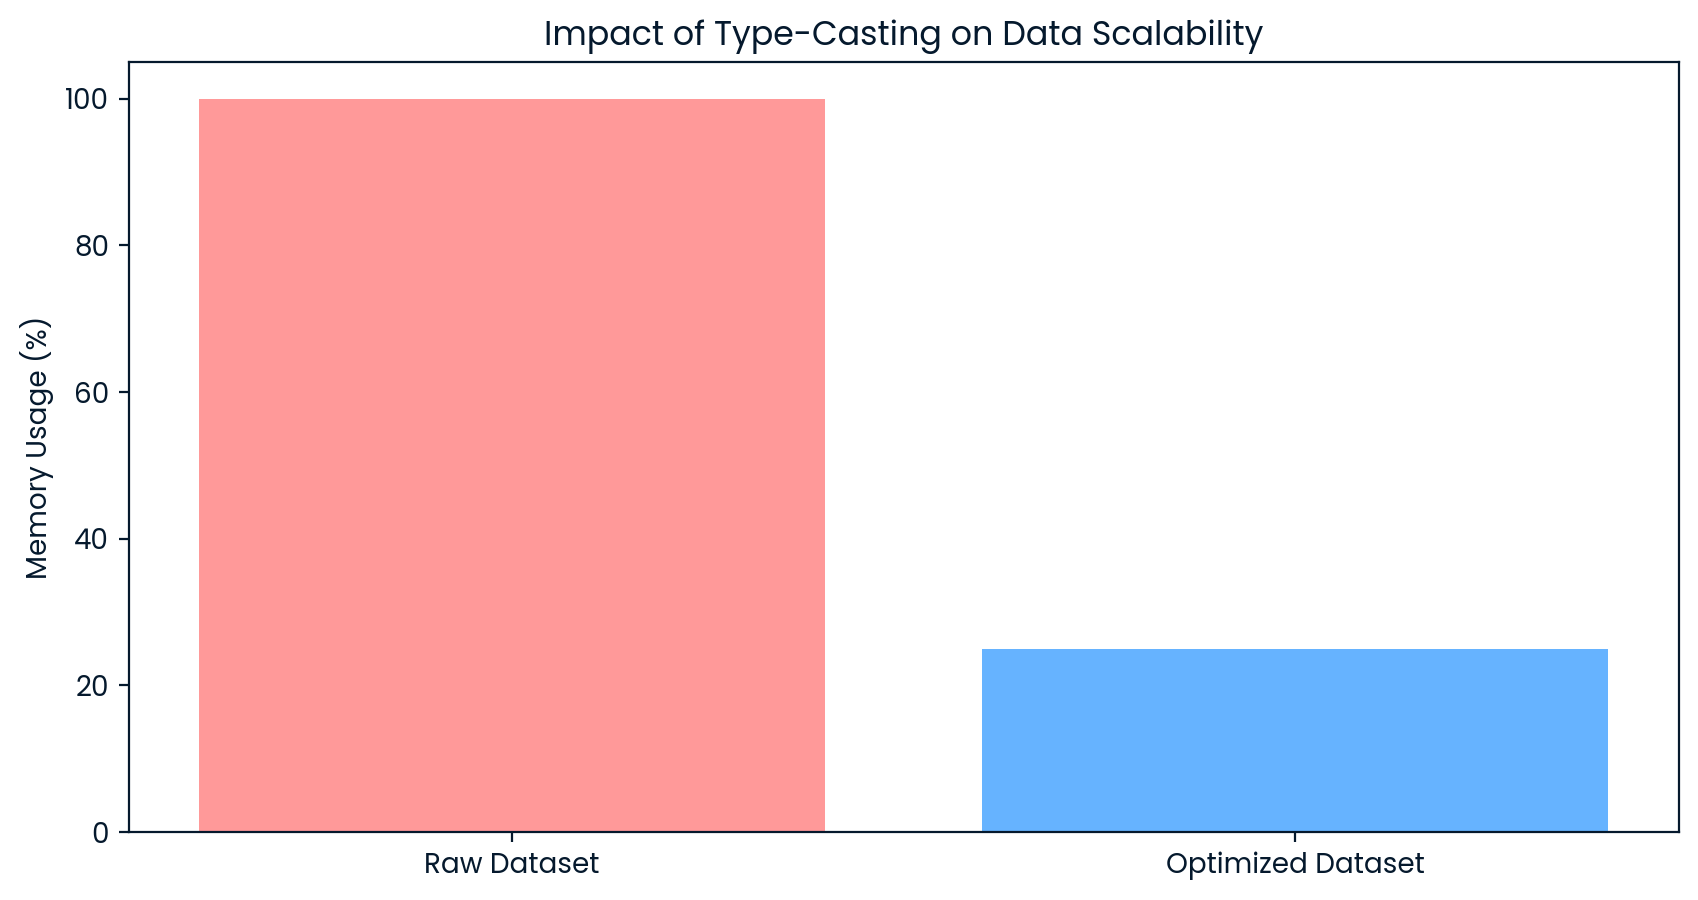

In [8]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and create a copy
ds_jobs = pd.read_csv("customer_train.csv")
ds_jobs_transformed = ds_jobs.copy()

# EDA to help identify ordinal, nominal, and two-factor categories
for col in ds_jobs.select_dtypes("object").columns:
    print(ds_jobs_transformed[col].value_counts(), '\n')

# Create a dictionary of columns containing ordered categorical data
ordered_cats = {
    'enrolled_university': ['no_enrollment', 'Part time course', 'Full time course'],
    'education_level': ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd'],
    'experience': ['<1'] + list(map(str, range(1, 21))) + ['>20'],
    'company_size': ['<10', '10-49', '50-99', '100-499', '500-999', '1000-4999', '5000-9999', '10000+'],
    'last_new_job': ['never', '1', '2', '3', '4', '>4']
}

# Create a mapping dictionary of columns containing two-factor categories to convert to Booleans
two_factor_cats = {
    'relevant_experience': {'No relevant experience': False, 'Has relevant experience': True},
    'job_change': {0.0: False, 1.0: True}
}

# Loop through DataFrame columns to efficiently change data types
for col in ds_jobs_transformed:
    
    # Convert two-factor categories to bool
    if col in ['relevant_experience', 'job_change']:
        ds_jobs_transformed[col] = ds_jobs_transformed[col].map(two_factor_cats[col])
    
    # Convert integer columns to int32
    elif col in ['student_id', 'training_hours']:
        ds_jobs_transformed[col] = ds_jobs_transformed[col].astype('int32')
    
    # Convert float columns to float16
    elif col == 'city_development_index':
        ds_jobs_transformed[col] = ds_jobs_transformed[col].astype('float16')
    
    # Convert columns containing ordered categorical data to ordered categories using dict
    elif col in ordered_cats.keys():
        category = pd.CategoricalDtype(ordered_cats[col], ordered=True)
        ds_jobs_transformed[col] = ds_jobs_transformed[col].astype(category)
    
    # Convert remaining columns to standard categories
    else:
        ds_jobs_transformed[col] = ds_jobs_transformed[col].astype('category')
        
# Filter students with 10 or more years experience at companies with at least 1000 employees
ds_jobs_transformed = ds_jobs_transformed[(ds_jobs_transformed['experience'] >= '10') & (ds_jobs_transformed['company_size'] >= '1000-4999')]


import os

# Create images directory
if not os.path.exists('images'):
    os.makedirs('images')

labels = ['Raw Dataset', 'Optimized Dataset']
memory_usage = [100, 25] 

plt.figure(figsize=(10, 5))
plt.bar(labels, memory_usage, color=['#ff9999','#66b3ff'])
plt.ylabel('Memory Usage (%)')
plt.title('Impact of Type-Casting on Data Scalability')
plt.savefig("images/memory_comparison.png", dpi=300)
plt.show()